# 2-5. 프로젝트: SentencePiece 사용하기

## Step 2. SentencePiece 모델 학습

```
def tokenize(corpus):  # corpus: Tokenized Sentence's List  
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')  
    tokenizer.fit_on_texts(corpus)  
  
    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer
``` 

위와 같이 tf.keras.preprocessing.text.Tokenizer에 corpus를 주고 tokenizer.fit_on_texts(corpus)를 하면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해주는 것


# sentencepiece 모델 학습 과정

```
import sentencepiece as spm
import os

temp_file = os.getenv('HOME') + '/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus: # 이전스텝에서 정제했던 corpus 사용
        f.write(str(row) + '\n')
        
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
# 위 train에서 --model_type = 'unigram'이 디폴트로 적용되어 있음. --model_type = 'bpe'로 옵션을 주어 변경 할 수 있음

!ls -l korean_spm*
```

위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 koreanspm.model 파일과 koreanspm.vocab vocabulary 파일이 생성되었음을 확인할 수 있습니다.

그럼 이렇게 학습된 SentencePiece 모델을 어떻게 활용하는지 살펴보겠습니다.

```
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# sentencepice를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1,0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))
```

# Step 3. Tokenizer 함수 작성

위에서 훈련시킨 sentencepiece를 활용하여 위 함수와 유사한 기능을 하는 Sp_tokenize()함수를 정의할 것.  
하지만 Sentencepice가 동작한느 방식이 단순 코튼화와는 달라 동일하게 정의하기는 어려움.  
그러니 아래 조건을 만족하는 함수를 정의  
1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2. 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

```

def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word
```

```
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)
```

# Step 4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기
아마 여러분들은 네이버 영화리뷰 감정분석 태스크를 한 번쯤은 다루어 보았을 것입니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용했을 것입니다.

만약 이 문제에서 tokenizer를 sentencepiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 비교해 보는 것도 흥미로울 것입니다.

네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

학습된 모델로 sp_tokenize() 메소드 구현하기

구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

(보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?

코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?


2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?

SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.


3. SentencePiece의 성능을 다각도로 비교분석하였는가?

SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

In [1]:
from konlpy.tag import Mecab

import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


import tensorflow as tf
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


In [2]:

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/aiffel_exp4_movie/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/aiffel_exp4_movie/sentiment_classification/ratings_test.txt')

print(len(train_data))
print(len(test_data))
train_data.head()

150000
50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터 결측치 및 중복 제거

In [3]:
# 결측치 확인
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64


In [4]:
# 데이터 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 
print(len(train_data), len(test_data))
print(train_data.isnull().sum())
print(test_data.isnull().sum())


146182 49157
id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


In [5]:
raw = list(train_data['document']) + list(test_data['document'])
    
print('data size :', len(raw))

print('example : ')
for sen in raw[0:100][::20]:print('>>', sen)

data size : 195339
example : 
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


# 데이터 분포 확인

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


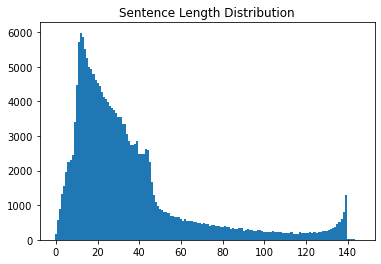

In [6]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)
print(sentence_length)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 길이가 1인 문장 확인

In [7]:
# 길이가 1인 문장 확인

def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count >100 : return
            
check_sentence_with_length(raw, 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


## 문장의 수가 1500 초과하는 문장 길이를 추출

In [8]:
# 필요해 보이는 문장 모두 확인

for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출
    if _sum > 1500:
        print('outlier index', idx+1)

outlier index 5
outlier index 6
outlier index 7
outlier index 8
outlier index 9
outlier index 10
outlier index 11
outlier index 12
outlier index 13
outlier index 14
outlier index 15
outlier index 16
outlier index 17
outlier index 18
outlier index 19
outlier index 20
outlier index 21
outlier index 22
outlier index 23
outlier index 24
outlier index 25
outlier index 26
outlier index 27
outlier index 28
outlier index 29
outlier index 30
outlier index 31
outlier index 32
outlier index 33
outlier index 34
outlier index 35
outlier index 36
outlier index 37
outlier index 38
outlier index 39
outlier index 40
outlier index 41
outlier index 42
outlier index 43
outlier index 44
outlier index 45
outlier index 46
outlier index 47


## 중복제거 안된 것을 확인


In [9]:
check_sentence_with_length(raw, 10)

# 중복제거 안된 것을 확인

매우 실망.....
정말쓰레기영화입니다
내일이 기대되는 `
재미있는영화입니다.
드라마 너무 재밓당
맛깔 나는 드라마.
영화가 내용이 없다
정체성은 사치인가?
재밌음 귀엽고 신남
키기키기키기키기키기
진짜 추천해요 ^^
이게뭔가요내용도없고
아름다운 영화였어요
배우가 아깝다 ,,
난 잼있던데..ㅎㅎ
그냥 다큐일뿐 ..
폭풍오열ㅠㅜㅠㅍ퓨ㅠ
안봐도 되는 영화.
최고의 농촌드라마.
진짜 잘 만든 수작
구우우웃~~!!!!
재밌습니돠다다다~~
이야기가 너무 뻔해
무삭제판보셈..ㅋㅋ
빨리다음편도나와라ㅠ
내생의 최고의 영화
망해라임권택작품들.
봐주기 아까운 영화
짱짱!!!!♥♥♥♥
... 무조건 보라
너무 극적인 시퀀스
이런걸..영화라고.
최고의 외화 그립다
100번쯤 본 영화
난 재미있는데 ㅋ?
이건 다시봐도 수작
진짜의학드라마의 갑
아주 썩어빠진 영화
너무 너무 좋네요!
1236547890
계속 울었다..ㅜㅜ
진짜 재미없다 ..
진짜 소름이 돋는다
좋아요...^^~~
가나다라마바사아자차
할말이없을정도로별로
Good,,,...
역시 이것도 쓰레기
어..이..상..실
모르면 말을마라~ㅋ
재미없다진짜진짜열자
괜찮은 스릴러다..
토토로의 움직이는성
재밌있어요001요원
개노답...ㅉㅉㅉㅉ
새로운 것이 없다.
으으으으ㅡ으으으리리
재미만 있더만...
충격적이고 슬픈영화
아 드럽게 재미없네
가슴이 많이아팟던듯
전작만도 못한 영화
정말 재미있습니다.
진짜재밌어요^^~♥
그저그럼10글자임.
멋집니다!! ^ㅇ^
아. 진짜 재미없다
신 구 의 조합~~
최고의 외화시리즈!
김민종씨 멋집니다.
감독아,안녕하시냐?
웃겨죽을뻔 했다..
Fhjkkdrybb
가슴이 찢어지드라.
재미있는 스토리..
음;;이해가 안되요
홀홀홀10점은드릴게
꼬마 안성기씨네..
너무높다 깎아줘야되
평점이왜이래....
올해 최악의 영화!
일뽕꺼져노잼이야노잼
모하자는 영화인지?
1편에 낚인건가..
장선우 쓰레기 영화
노잼노잼노잼노잼노잼
토끼 귀여워요!!!
또보고싶다 ㅋㅋㅋㅋ
그냥 만든놈이 OO
나름 재미있네요 ㅎ
훈훈하당~!~!~!

# 이건 중복이 아닌 것 같은데? 그냥.. 글자수..? 10이면 10글자..

data size :  194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


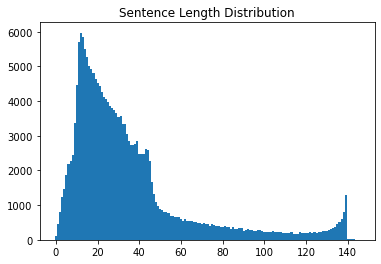

In [10]:
# set()은 집합을 정의하는 자료형인데 중복을 허용하지 않음
# 그래서 자동으로 중복된 요소를 제거
# 대신 list의 순서가 뒤죽박죽 섞일 수 있으니 번역데이터처럼 쌍을 이뤄야 하는 데이터라면 주의 해야함

min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw)) # set을 사용하여 중복 제거
print('data size : ', len(cleaned_corpus))


for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)
print(sentence_length)

for sen in cleaned_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 여기서는 길이 100이상 데이터는 제거

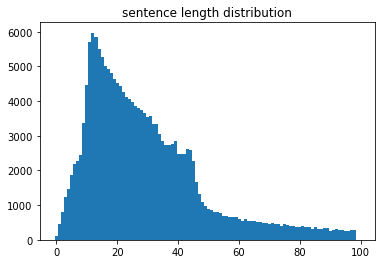

In [11]:
max_len = 100
min_len = 0

# 길이 조건에 맞는 데이터만 검색
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) and (len(s) >= min_len)]

# 분포도 다시 그리기
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
#     print(sentence_length[len(sen)-1], end='')
#     print(sentence_length[len(sen)], end='')
    
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('sentence length distribution')
plt.show()

## sentencepice 학습

In [12]:
# sentencepiece 모델 학습 과정

import sentencepiece as spm
import os

temp_file = os.getenv('HOME') + '/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus: # 이전스텝에서 정제했던 corpus 사용
        f.write(str(row) + '\n')
        
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
# 위 train에서 --model_type = 'unigram'이 디폴트로 적용되어 있음. --model_type = 'bpe'로 옵션을 주어 변경 할 수 있음

!ls -l korean_spm*

-rw-r--r-- 1 aiffel-dj47 aiffel-dj47 375094  4월 14 10:06 korean_spm.model
-rw-r--r-- 1 aiffel-dj47 aiffel-dj47 144530  4월 14 10:06 korean_spm.vocab


In [13]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1510, 9, 406, 15, 1345, 9, 138, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [14]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=100)

    return tensor, word_index, index_word


In [15]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)


[[ 562 3393   14 1380 2219    4    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1581 2277  253  590    9    3   16 7937  687    8    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [16]:
s = spm.SentencePieceProcessor()

s.Load('korean_spm.model')
tensor, word_index, index_word = sp_tokenize(s, raw)
print(tensor)
print(len(tensor[0]))

[[  57  864    5 ...    0    0    0]
 [1577    8 4522 ...    0    0    0]
 [  22  391 7767 ...    0    0    0]
 ...
 [2142   11  587 ...    0    0    0]
 [ 571 1321   12 ...    0    0    0]
 [1903   12  204 ...    0    0    0]]
100


In [17]:
tensor.shape

(195339, 100)

## 모델구성 및 validation set 구성

In [23]:
# 데이터 분할
x_train = tensor[:146182]
x_test = tensor[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 30000건 분리 train set의 약 20%
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 30000건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 100)
(116182,)


# RNN 모델 구성

In [56]:
# RNN 모델 구성
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

rnn_ver1_model = keras.Sequential()
rnn_ver1_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_ver1_model.add(keras.layers.LSTM(8))
rnn_ver1_model.add(keras.layers.Dense(128, activation='relu'))
rnn_ver1_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_ver1_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 1,004,769
Trainable params: 1,004,769
Non-trainable params: 0
_________________________________________________________________


In [57]:
rnn_ver1_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = rnn_ver1_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

train_loss, train_accuracy = rnn_ver1_model.evaluate(partial_x_train, partial_y_train, verbose=2)

print("train_loss: {} ".format(train_loss))
print("train_accuracy: {}".format(train_accuracy))

Epoch 1/50
227/227 [==============================] - 5s 24ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.5024
Epoch 2/50
227/227 [==============================] - 5s 22ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 3/50
227/227 [==============================] - 5s 24ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 4/50
227/227 [==============================] - 5s 24ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5023
Epoch 5/50
227/227 [==============================] - 5s 23ms/step - loss: 0.6931 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 6/50
227/227 [==============================] - 5s 23ms/step - loss: 0.6931 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5019
Epoch 7/50
227/227 [==============================] - 5s 24ms/step - loss: 0.6929 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4981

In [58]:
results = rnn_ver1_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.6930 - accuracy: 0.5044
[0.6929667592048645, 0.5043635964393616]


In [59]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


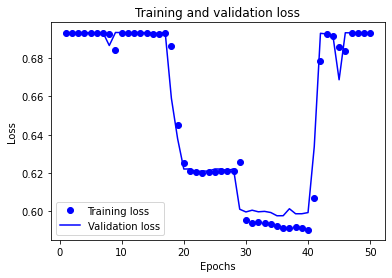

In [60]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# RNN 모델 구성

In [63]:
# RNN 모델 구성
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

rnn_ver2_model = keras.Sequential()
rnn_ver2_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_ver2_model.add(keras.layers.LSTM(8))
rnn_ver2_model.add(keras.layers.Dense(128, activation='relu'))
rnn_ver2_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_ver2_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_16 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 1,004,769
Trainable params: 1,004,769
Non-trainable params: 0
_________________________________________________________________


In [64]:
rnn_ver2_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=100  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = rnn_ver2_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

train_loss, train_accuracy = rnn_ver2_model.evaluate(partial_x_train, partial_y_train, verbose=2)

print("train_loss: {} ".format(train_loss))
print("train_accuracy: {}".format(train_accuracy))

Epoch 1/100
227/227 [==============================] - 6s 25ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 2/100
227/227 [==============================] - 5s 24ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 3/100
227/227 [==============================] - 5s 23ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 4/100
227/227 [==============================] - 5s 22ms/step - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 5/100
227/227 [==============================] - 5s 23ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 6/100
227/227 [==============================] - 5s 23ms/step - loss: 0.6930 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 7/100
227/227 [==============================] - 5s 22ms/step - loss: 0.6929 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy:

227/227 [==============================] - 5s 22ms/step - loss: 0.0494 - accuracy: 0.9892 - val_loss: 0.7530 - val_accuracy: 0.8313
Epoch 58/100
227/227 [==============================] - 5s 23ms/step - loss: 0.0486 - accuracy: 0.9896 - val_loss: 0.7732 - val_accuracy: 0.8303
Epoch 59/100
227/227 [==============================] - 5s 22ms/step - loss: 0.0471 - accuracy: 0.9900 - val_loss: 0.7656 - val_accuracy: 0.8304
Epoch 60/100
227/227 [==============================] - 5s 22ms/step - loss: 0.0469 - accuracy: 0.9899 - val_loss: 0.7897 - val_accuracy: 0.8292
Epoch 61/100
227/227 [==============================] - 5s 22ms/step - loss: 0.0501 - accuracy: 0.9888 - val_loss: 0.7686 - val_accuracy: 0.8321
Epoch 62/100
227/227 [==============================] - 5s 23ms/step - loss: 0.0463 - accuracy: 0.9900 - val_loss: 0.8014 - val_accuracy: 0.8309
Epoch 63/100
227/227 [==============================] - 5s 23ms/step - loss: 0.0437 - accuracy: 0.9909 - val_loss: 0.7728 - val_accuracy: 0.830

In [65]:
results = rnn_ver2_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.8763 - accuracy: 0.8254
[0.8762616515159607, 0.8254368901252747]


In [66]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


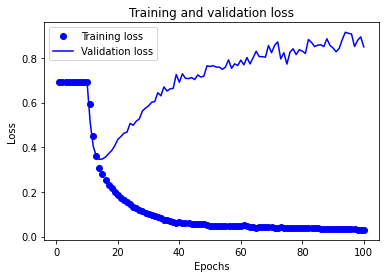

In [67]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Mecab 사용

In [68]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print("ok")

ok


In [69]:
index_to_word = {index:word for word, index in word_to_index.items()} 
print("ok")
# 위에 word_to_index아래에 썼을 땐 실행은 되지만 print로 출력해보면 안나옴

ok


In [70]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]
print("ok")

ok


# 3) 모델구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [71]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 611, 4, 4, 40, 228, 20, 33, 743]
라벨:  0
1번째 리뷰 문장 길이:  9
2번째 리뷰 문장 길이:  17


In [72]:
print(word_to_index["ㅋㅋㅋ"])     # '69' 가 출력됩니다. 
print(index_to_word[69])
print(len(word_to_index))
print(len(index_to_word))

191
해
10000
10000


In [73]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.94005805292338
문장길이 최대 :  116
문장길이 표준편차 :  12.836374051220329


In [74]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9345087258560758%가 maxlen 설정값 이내에 포함됩니다. 


# 패딩 추가

In [75]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [76]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0


In [77]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0  32 611   4   4
  40 228  20  33 743]
라벨:  0
1번째 리뷰 문장 길이:  41
2번째 리뷰 문장 길이:  41


# 4) 모델구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [78]:
# validation set 30000건 분리 train set의 약 20%
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 30000건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


# 5) 모델 훈련 개시

## RNN

In [79]:
# RNN 모델 구성
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

rnn_ver3_model = keras.Sequential()
rnn_ver3_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_ver3_model.add(keras.layers.LSTM(8))
rnn_ver3_model.add(keras.layers.Dense(128, activation='relu'))
rnn_ver3_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_ver3_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
lstm_9 (LSTM)                (None, 8)                 416       
_________________________________________________________________
dense_18 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 129       
Total params: 41,697
Trainable params: 41,697
Non-trainable params: 0
_________________________________________________________________


# 학습 개시

In [80]:
rnn_ver3_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = rnn_ver3_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

train_loss, train_accuracy = rnn_ver3_model.evaluate(partial_X_train, partial_y_train, verbose=2)

print("train_loss: {} ".format(train_loss))
print("train_accuracy: {}".format(train_accuracy))

Epoch 1/5
227/227 [==============================] - 1s 5ms/step - loss: 0.5006 - accuracy: 0.7483 - val_loss: 0.3632 - val_accuracy: 0.8414
Epoch 2/5
227/227 [==============================] - 1s 4ms/step - loss: 0.3428 - accuracy: 0.8540 - val_loss: 0.3460 - val_accuracy: 0.8496
Epoch 3/5
227/227 [==============================] - 1s 4ms/step - loss: 0.3229 - accuracy: 0.8646 - val_loss: 0.3458 - val_accuracy: 0.8494
Epoch 4/5
227/227 [==============================] - 1s 4ms/step - loss: 0.3128 - accuracy: 0.8698 - val_loss: 0.3511 - val_accuracy: 0.8480
Epoch 5/5
227/227 [==============================] - 1s 4ms/step - loss: 0.3065 - accuracy: 0.8720 - val_loss: 0.3593 - val_accuracy: 0.8463
3631/3631 - 6s - loss: 0.2960 - accuracy: 0.8782
train_loss: 0.29603612422943115 
train_accuracy: 0.8781825304031372


In [82]:
# 테스트셋 평가
results = rnn_ver3_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3679 - accuracy: 0.8414
[0.36787649989128113, 0.8414061069488525]


# 6) Loss, Accuracy 그래프 시각화

In [85]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


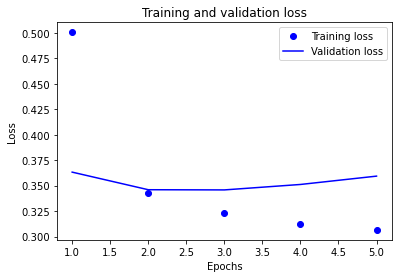

In [87]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 총평

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?  
코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?

2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?  
SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.

3. SentencePiece의 성능을 다각도로 비교분석하였는가?  
SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

이전 익스 노드인 네이버 영화 리뷰 분석을 참고해서 진행했다.  
이걸 내가 했다기 보다 이거보고 저거보고 해서 어찌어찌 된 느낌이다.  

그래도 긍정적인 것은 dp2에서 토큰화에 대해 좀 알 수 있었는데 공백기반과 형태소기반에 대해서는 조금? 감이 잡히지만 sentencepiece는 뭔지 잘 모르겠고 아직도 인공지능을 어떻게 해서 모델에 적용시키는지 잘 모르겠다. 아직도 정확한 느낌이 안 오는 것 같다. 뭔가 알듯하다가 다시 모르는 기분..

어쨋든 결과값은 출력했고 초기에 epoch를 작게하니 accuracy가 50%정도가 나오길래 epoch를 높혔더니 80%이상을 얻을 수 있었다.  
그러나 training loss와 val loss가 저렇게 멀어지는 건 별로 안 좋다고 했던 것 같은데? 저걸 어떻게 조정해야하는지는 모르겠다.  

mecab을 사용했을땐 이전 노드를 그대로 복사해서 왔는데 epoch5만으로도 80% 이상의 성능이 나왔다.

이것만 보면 내가 sentencepice를 제대로 적용하지 못한 것 같다.